In [1]:
import glob
import tqdm
from nltk import word_tokenize
import spacy
import string
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import collections
#from __future__ import print_function
import argparse
import os
import json
import time
import logging
import re
from collections import Counter
import string
import matplotlib.pyplot as plt
punctuations = list(string.punctuation)

In [2]:
def readFileNew_withTime(filename):
    '''
    This function is used to find out how much time a user would need to respond to a question
    input: transcript file name
    output: a list with timestamps within one transcript
    e.g. ['2019-03-31 12:32', '2019-03-31 12:32', ...]
    '''
    f = open(filename,"r")
    temp_list = []
    c = 0
    personName = ''
    botName = ''
    count = 0
    for i, line in enumerate(f):
        #print(line)
        c+=1
        if i==0:
            indBotNameSt = line.find(']')+1
            #first ":" appears in the timestamp
            indFirstCoBotName = line.find(':')
            indSecondCoBotName = indFirstCoBotName + line[indFirstCoBotName+1:].find(':') + 1
            botName = line[indBotNameSt:indSecondCoBotName].strip()
                
        elif not personName:            
            indPersonNameSt = line.find(']')+1
            indFirstCoPersonName = line.find(':')
            indSecondCoPersonName = indFirstCoPersonName + line[indFirstCoPersonName+1:].find(':') + 1
            tmpName = line[indPersonNameSt:indSecondCoPersonName].strip()
            if tmpName != botName:
                personName = tmpName
                    
        if line[1:3]=='20': #check if start with date
            if '{' not in line:
                indSentenceSt = line.find(']')+1
                temp_list.append(line[:indSentenceSt])
            else:
                indSentenceSt = line.find(']')+1
                if 'wording' in line:
                    temp_text = line[line.find(':wording')+8 : line.find(':qid')]
                    temp_list.append(line[:indSentenceSt])
                    #temp_list.append(botName+': single or multi'+str(count)+'ple choice Q')
                    count+=1
                else:
                    if botName not in line:
                        temp_list.append(line[:indSentenceSt])
            temp_list[-1] = temp_list[-1].rstrip('\n')
            
    return temp_list

def readFileNew(filename):
    '''
    input: transcript file name
    output: a list contains all the text
    e.g. ['Juji: Can you introduce yourself?', 'User: I love swimming', 'Juji: Thank you! Goodbye.']
    '''
    f = open(filename,"r")
    temp_list = []
    c = 0
    personName = ''
    botName = ''
    count = 0
    for i, line in enumerate(f):
        #print(line)
        c+=1
        if i==0:
            indBotNameSt = line.find(']')+1
            #first ":" appears in the timestamp
            indFirstCoBotName = line.find(':')
            indSecondCoBotName = indFirstCoBotName + line[indFirstCoBotName+1:].find(':') + 1
            botName = line[indBotNameSt:indSecondCoBotName].strip()
                
        elif not personName:            
            indPersonNameSt = line.find(']')+1
            indFirstCoPersonName = line.find(':')
            indSecondCoPersonName = indFirstCoPersonName + line[indFirstCoPersonName+1:].find(':') + 1
            tmpName = line[indPersonNameSt:indSecondCoPersonName].strip()
            if tmpName != botName:
                personName = tmpName
                    
        if line[1:3]=='20': #check if start with date
            if '{' not in line:
                indSentenceSt = line.find(']')+2
                temp_list.append(line[indSentenceSt:])
            else:
                if 'wording' in line:
                    subline = line[line.find(':wording')+8 : ]
                    temp_text = subline[:subline.index(',')]
                    if '<' in temp_text and '>' in temp_text and '*' in temp_text:
                        ind1, ind2 = temp_text.index('<'), temp_text.index('>')
                        temp_text = temp_text[:ind1]+temp_text[ind2+1:]
                        ind1, ind2 = temp_text.index('<'), temp_text.index('>')
                        temp_text = temp_text[:ind1]+temp_text[ind2+1:]
                        temp_text = temp_text.replace('*','')
                    temp_list.append(botName + ': ' + temp_text)
                    #temp_list.append(botName+': single or multi'+str(count)+'ple choice Q')
                    count+=1
                else:
                    if botName not in line:
                        temp_list.append(personName+': A')
            temp_list[-1] = temp_list[-1].rstrip('\n')
            
    return temp_list,count,botName

#remove transcrips that do not chat
def filterNonChattingTranscripts(transcripts_name):
    '''
    This function filters out empty transctipts
    input: a list of transcript files names
    output: 
        transcripts_afterFilter: a list with 'readFileNew' funtion's return value
        transcripts_withTime_afterFilter: a list with 'readFileNew_withTime' function's return value
        resbotName: bot's name
    '''
    all_transcripts = []
    filtered_transcripts = []
    
    transcripts_afterFilter = []
    count_choiceQuestions = []
    transcripts_withTime_afterFilter = []
    for i in range(len(transcripts_name)):
        t,c,botName = readFileNew(transcripts_name[i])
        t_time = readFileNew_withTime(transcripts_name[i])
        if botName != '':
            resbotName = botName
        all_transcripts.append(t)
        flag = True
        for j in range(len(t)):
            if not t[j].startswith(resbotName):
                flag = False
                break
                
        if flag:
            filtered_transcripts.append(t)
        else:
            transcripts_afterFilter.append(t)
            count_choiceQuestions.append(c)
            
            transcripts_withTime_afterFilter.append(t_time)
    return transcripts_afterFilter, transcripts_withTime_afterFilter,resbotName

#get question blocks
def groupQuestions(sentences,sentences_time,questions,botName):
    '''
    input: 
        sentences: the sentences list from "readFileNew" function's return value
        sentences_time: the timestamp list from "readFileNew_withTime" function's return value
        questions: question list
        botName
        
    output: 
        questionDict: a dict with key = question in question list, value = conversation block under the key question
        e.g {'q1': ['Juji: q1', 'User: answer to q1'], ...}
        
        questionDict_Time: a dict with key = question in question list, value = timestamp of the conversation block
        e.g {'q1': ['timestamp1', 'timestampe2'], ...}
    '''
    #sentences = readFile(filename)
    temp_list=[]
    last= 0
    lastq = 'starting'
    #nlp = spacy.load('en_pytt_bertbaseuncased_lg')
    Th = 0.7
    questionDict = collections.OrderedDict()
    questionDict_time = collections.OrderedDict()
    for i in range(len(sentences)):
        match = 0
        if sentences[i].startswith(botName+':'):#[:5] == 'Juji:':
            sen_rmPunct = ' '.join([i.strip("".join(punctuations)) for i in word_tokenize(sentences[i].strip()) if i not in punctuations])
            #print(sen_rmPunct)
            for q in questions:
                if q in sen_rmPunct:
                    match = 1   
                    
                    if lastq in questionDict:
                        questionDict[lastq] += sentences[last:i]
                        questionDict_time[lastq] += sentences_time[last:i]
                    else:
                        questionDict[lastq] = sentences[last:i]
                        questionDict_time[lastq] = sentences_time[last:i]
                    lastq = q
                    #temp_list.append(sentences[last:i])
                    last = i

    #temp_list.append(sentences[last:])
    if lastq in questionDict:
        questionDict[lastq] += sentences[last:]
        questionDict_time[lastq] += sentences_time[last:]
    else:
        questionDict[lastq] = sentences[last:]
        questionDict_time[lastq] = sentences_time[last:]
    #print(questionDict)
    return questionDict, questionDict_time#list(questionDict.values())



In [3]:
#read from edn file to get question list
def getQuestions(filename):
    '''
    input: edn file name
    output: question list with punctuations removed
    '''
    QList = []
    with open(filename) as f:
        lines = f.readlines()
        flag = 0
        for line in lines:
            if flag:
                lBracket, rBracket = line.find('['), line.find(']')
                question = line[lBracket+2:rBracket-1]
                QList.append(question)
                flag = 0
                continue
            if ':wording' in line and ';;' not in line:
                flag = 1
    for i in range(len(QList)):
        if 'Are you working for' in QList[i]:
            QList[i] = 'Are you working for?'
    
    for j in range(len(QList)):
            QList[j]=QList[j].rstrip('\r')
            QList[j]=QList[j].replace("\r", " ")
            QList[j]=QList[j].strip()
            QList[j] = ' '.join([k.strip("".join(punctuations)) for k in word_tokenize(QList[j]) if k not in punctuations])
        
    return QList

In [4]:
def groupQuestions_csv(filename):
    '''
    input: 
        csv file name
        
    output: 
        qBlocks: a dict with key = question in question list, value = conversation block under the key question
        e.g {'q1': ['Juji: q1', 'User: answer to q1'], ...}
        qList: question list
        
    '''
    df = pd.read_csv(filename,encoding='iso8859-1')
    botName = 'Juji'
    qBlocks = []
    qList = df.columns.tolist()[5:]
    finalQuestion = 'Any final thoughts?'
    
    qList_addtional = qList[qList.index(finalQuestion)+1:]
    qList_normal = qList[:qList.index(finalQuestion)+1]
    for i in range(len(df)):
        block = collections.OrderedDict()
        line = df.iloc[i]
        if pd.isnull(line[qList[0]]):
            continue
        for q in qList_normal:
            if not pd.isnull(line[q]):
                block[q] = [botName+':'+q, line['Name']+':'+str(line[q])]
        qBlocks.append(block)
    
    return qBlocks,qList_normal


In [5]:
def getResponseRate(qList, trans_block,botName):
    '''
    input: 
        qList: question list
        trans_block: a list of dicts with key = question in question list, value = conversation block under the key question
        e.g [{'q1': ['Juji: q1', 'User1: answer to q1'], ...}, {'q1': ['Juji: q1', 'User2: answer to q1'], ...} ... ]
        botName
        
    output: 
        response: a dict with key = question in question list, value = response rate
    
    '''
    response = { i : 0 for i in qList }
    for block in trans_block:
        for question in block:
            if question in response and len(block[question])>1:
                for line in block[question]:
                    if line[:line.index(':')]!=botName:
                        response[question] += 1
                        break
    for q in response:
        response[q] = response[q]/len(trans_block)
    
    
    
    return response

In [6]:
def responseRateVis(qList, responseRate):
    rate = [responseRate[q] for q in qList]
    ind = list(range(len(rate)))
    plt.plot(qList,rate)
    plt.xticks(rotation=90)
    plt.show()
    

In [7]:
def main(readCsv=False,csvFileName=None, transcriptFilesPath=None,qListPath=None):
    
    if readCsv:
        transcripts_blocks,q = groupQuestions_csv(csvFileName)
        botName = 'Juji'
        responseRate = getResponseRate(q,transcripts_blocks,botName)
        
    else:
        transcripts_blocks = []
        transcripts_name = glob.glob(transcriptFilesPath)
        transcripts_afterFilter, transcripts_withTime_afterFilter,botName = filterNonChattingTranscripts(transcripts_name)
        q = getQuestions(qListPath)
        for i in tqdm.tqdm_notebook(range(len(transcripts_afterFilter))):
            trans_block, trans_block_time = groupQuestions(transcripts_afterFilter[i],transcripts_withTime_afterFilter[i],q,botName)
            transcripts_blocks.append(trans_block)
        responseRate = getResponseRate(q,transcripts_blocks,botName)
    responseRateVis(q,responseRate)
    return responseRate

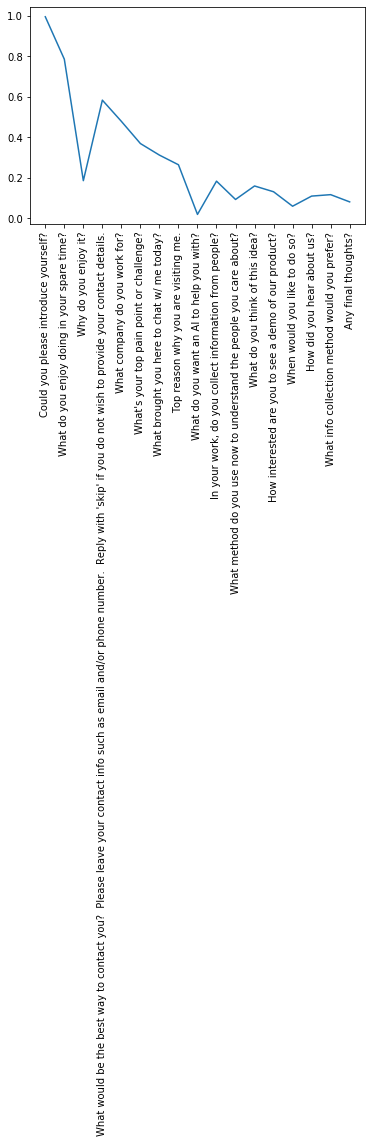

In [8]:
#if input is a csv file
responseRate = main(True,'test-set/welcome.csv')

In [9]:
responseRate

{'Any final thoughts?': 0.08095238095238096,
 'Could you please introduce yourself?': 0.9952380952380953,
 'How did you hear about us?': 0.10952380952380952,
 'How interested are you to see a demo of our product?': 0.13095238095238096,
 'In your work, do you collect information from people?': 0.18333333333333332,
 'Top reason why you are visiting me.': 0.2642857142857143,
 'What brought you here to chat w/ me today?': 0.3119047619047619,
 'What company do you work for?': 0.4785714285714286,
 'What do you enjoy doing in your spare time?': 0.7857142857142857,
 'What do you think of this idea?': 0.1595238095238095,
 'What do you want an AI to help you with?': 0.01904761904761905,
 'What info collection method would you prefer?': 0.11666666666666667,
 'What method do you use now to understand the people you care about?': 0.09285714285714286,
 "What would be the best way to contact you?  Please leave your contact info such as email and/or phone number.  Reply with 'skip' if you do not wish 

/Users/hanxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


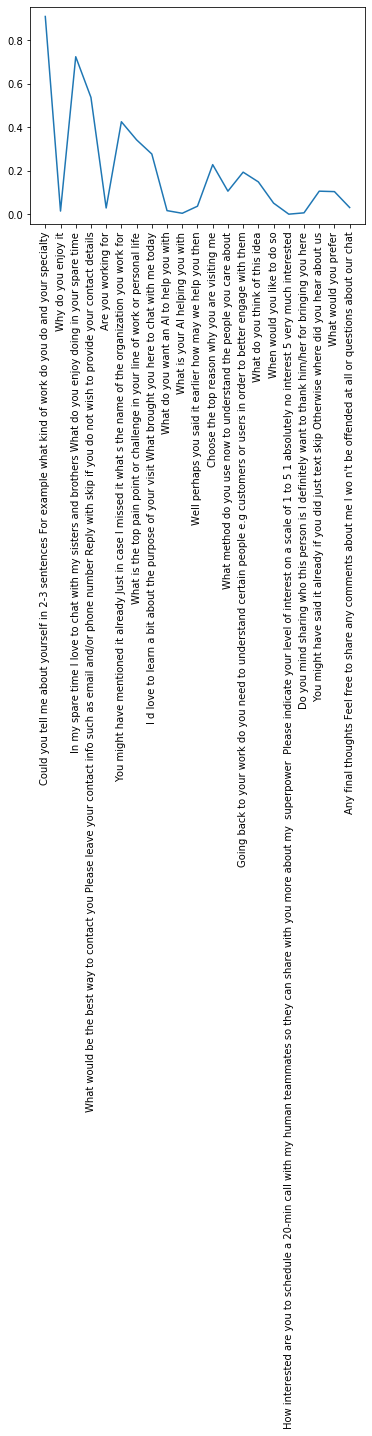

In [10]:
#if input is transcripts
responseRate = main(False,None,'test-set/welcome-transcripts/*.txt','test-set/welcome.edn')

In [11]:
responseRate

{"Any final thoughts Feel free to share any comments about me I wo n't be offended at all or questions about our chat": 0.03048780487804878,
 'Are you working for': 0.028455284552845527,
 'Choose the top reason why you are visiting me': 0.22764227642276422,
 'Could you tell me about yourself in 2-3 sentences For example what kind of work do you do and your specialty': 0.9085365853658537,
 'Do you mind sharing who this person is I definitely want to thank him/her for bringing you here': 0.006097560975609756,
 'Going back to your work do you need to understand certain people e.g customers or users in order to better engage with them': 0.19308943089430894,
 'How interested are you to schedule a 20-min call with my human teammates so they can share with you more about my  superpower  Please indicate your level of interest on a scale of 1 to 5 1 absolutely no interest 5 very much interested': 0.0,
 'I d love to learn a bit about the purpose of your visit What brought you here to chat with m

Problem: follow-up question's rate's denominator should be the times of the question asked, not #trancripts